In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import albumentations as A
import xml.dom.minidom as xdom

In [2]:
class TrainingConfigs:
    # Dirs info
    path_to_dataset = "datasets/obd_fundus"
    images_dir = "images"
    labels_dir = "labels"
    # Data info
    image_dims = (512, 512)
    max_boxes_per_image = 100
    batch_size = 1
    shuffle_size = 16
    # Model info
    num_classes = 8
    mpl_optimizer_momentum = 0.9
    mpl_optimizer_nesterov = True
    # Training info
    epochs = 10

Dataset

In [3]:
# loading the labels'
def parse_label_file(path_to_label_file):
    """Parses file with labels and converts into dict. For object detection."""
    labels = open(path_to_label_file)
    label_dict = {}
    label_list = []
    for label in labels:
        label_class, label_index = label.split()
        label_dict[label_class] = label_index
        label_list.append(label_class)
    return label_dict

def show_boxes(image, boxes):
    """Boxes should be [num boxes, x min, y min, x max, y max, label] """
    for box in boxes:
        # [xmin, ymin, xmax, ymax, l]
        xmin, ymin, xmax, ymax, l = box
        xmin = int(image.shape[1] * xmin)
        xmax = int(image.shape[1] * xmax)
        ymin = int(image.shape[0] * ymin)
        ymax = int(image.shape[0] * ymax)
        image = cv2.rectangle(
            image, 
            (xmin, ymin),
            (xmax, ymax),
            (255, 255, 255),
            3)
    plt.imshow(image)
    plt.show()

labels = parse_label_file(TrainingConfigs.path_to_dataset + "/labels.txt")

print(labels)

{'cotton_wool_spot': '0', 'drusen': '1', 'geography_atrophy': '2', 'hard_exudates': '3', 'hemorrhages': '4', 'optic_disc': '5', 'macula': '6', 'microaneurysms': '7'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input shapes:  (1, 512, 512, 3)
Label shapes:  (1, 100, 5)


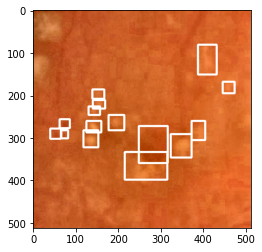

In [4]:
# The full tf.data pipline
class Dataset():
    def __init__(
        self, 
        file_names, 
        training_configs = TrainingConfigs):
        self.file_names = file_names
        self.training_configs = training_configs
        self.image_dims = training_configs.image_dims
    

    def augmentation(self, image, boxes):
        """For augmenting images and bboxes."""
        transform = A.Compose(
            [A.Flip(p = 0.75),
             A.Rotate(p = 0.5),
             A.Resize(
                 height = self.image_dims[1],
                 width = self.image_dims[1])], 
            bbox_params = A.BboxParams(
                format="albumentations"))
        aug = transform(
            image = image, 
            bboxes = boxes)
        image = np.array(aug["image"])
        bboxes = np.array(
            list(map(list, aug["bboxes"])))
        return image, bboxes


    def fundus_preprocessing(self, image):
        """An improved luminosity and contrast enhancement 
        framework for feature preservation in color fundus images"""
        # RGB to HSV
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        H,S,V = cv2.split(image_hsv)
        # Gamma adjustment on V Channe;
        gamma_val = 1/2.2
        gamma_tab = [((i / 255) ** gamma_val) * 255 for i in range(256)]
        table = np.array(gamma_tab, np.uint8)
        gamma_V = cv2.LUT(V, table)
        image_hsv_gamma = cv2.merge((H, S, gamma_V))
        # HSV to RGB to LAB
        image_lab = cv2.cvtColor(
            cv2.cvtColor(
                image_hsv_gamma, cv2.COLOR_HSV2RGB),
            cv2.COLOR_RGB2LAB)
        # CLAHE on L Channel
        l,a,b = cv2.split(image_lab)
        clahe = cv2.createCLAHE(
            clipLimit=2.5, 
            tileGridSize=(8,8))
        l = clahe.apply(l)
        lab_image = cv2.merge((l,a,b))
        # Convert image back to rgb
        image_processed = cv2.cvtColor(
            lab_image, cv2.COLOR_LAB2RGB)
        return image_processed


    def parse_xml(self, path_to_label):
        """Parses the PascalVOC XML Type file."""
        obj_and_box_list = []
        contents = xdom.parse(path_to_label)
        annotation = contents.documentElement
        size = annotation.getElementsByTagName("size")
        image_height = 0
        image_width = 0
        # Find the width and height of the original image
        for s in size:
            image_height = int(
                s.getElementsByTagName(
                    "height")[0].childNodes[0].data)
            image_width = int(
                s.getElementsByTagName(
                    "width")[0].childNodes[0].data)
        obj = annotation.getElementsByTagName("object")
        # Find all of the bounding boxes
        for o in obj:
            o_list = []
            obj_name = o.getElementsByTagName(
                "name")[0].childNodes[0].data
            bndbox = o.getElementsByTagName("bndbox")
            for box in bndbox:
                xmin = box.getElementsByTagName(
                    "xmin")[0].childNodes[0].data
                ymin = box.getElementsByTagName(
                    "ymin")[0].childNodes[0].data
                xmax = box.getElementsByTagName(
                    "xmax")[0].childNodes[0].data
                ymax = box.getElementsByTagName(
                    "ymax")[0].childNodes[0].data
                x_min = float(int(xmin)/image_width)
                y_min = float(int(ymin)/image_height)
                x_max = float(int(xmax)/image_width)
                y_max = float(int(ymax)/image_height)
                o_list.append(x_min)
                o_list.append(y_min)
                o_list.append(x_max)
                o_list.append(y_max)
                break
            o_list.append(int(labels[obj_name]))
            obj_and_box_list.append(o_list)
        return obj_and_box_list


    def pad_bboxes(self, box):
        """Pads the bounding boxes."""
        padding_boxes = self.training_configs.max_boxes_per_image \
            - len(box)
        # Append "zero boxes" to pad the list
        if padding_boxes > 0:
            for boxes in range(padding_boxes):
                box.append([0,0,0,0, -1])
        return box


    def parse_process_image(self, file_name):
        file_name = bytes.decode(file_name, encoding="utf-8")
        image = cv2.imread(file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_dims)
        image = self.fundus_preprocessing(image)
        image = image/255 # Normalize
        image = np.array(image, np.float32)
        return image
    

    def parse_process_voc(self, file_name):
        file_name = bytes.decode(file_name, encoding="utf-8")
        labels = self.parse_xml(file_name)
        labels = self.pad_bboxes(labels)
        labels = np.array(labels, np.float32)
        return labels
    

    def create_dataset(self):
        # List of the filepaths for images and labels
        images_paths = [
            os.path.join(
                self.training_configs.path_to_dataset,
                self.training_configs.images_dir,
                file + ".jpg") for file in self.file_names]
        labels_paths = [
            os.path.join(
                self.training_configs.path_to_dataset,
                self.training_configs.labels_dir,
                file + ".xml") for file in self.file_names]
        # Create the dataset object for the images
        image_list_ds = tf.data.Dataset.from_tensor_slices(images_paths)
        l_image_ds = image_list_ds.map(
            lambda x: tf.numpy_function(
                self.parse_process_image,
                inp=[x],
                Tout=tf.float32,
                name="l_parse_image"),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
            name = "l_image_map_ds")
        # Create the dataset object for the labels
        label_list_ds = tf.data.Dataset.from_tensor_slices(labels_paths)
        l_label_ds = label_list_ds.map(
            lambda x: tf.numpy_function(
                self.parse_process_voc,
                inp=[x],
                Tout=tf.float32,
                name="l_parse_label"),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
            name = "bbox_map_ds")
        # Zip dataset and apply training configs
        ds = tf.data.Dataset.zip((l_image_ds, l_label_ds))
        ds = ds.shuffle(
            buffer_size = self.training_configs.shuffle_size)
        ds = ds.batch(
            self.training_configs.batch_size)
        ds = ds.prefetch(
            buffer_size = tf.data.experimental.AUTOTUNE)
        return ds
    
def get_files(TrainingConfigs = TrainingConfigs):
    """Creates a list of the files."""
    image_file = open(
        TrainingConfigs.path_to_dataset + "\labeled_train.txt", "r")
    image_file_names = image_file.readlines()
    image_file_names = [name.strip() for name in image_file_names]
    
    return image_file_names

# Test the dataset pipeline
file_names = get_files()
training_dataset = Dataset(file_names, TrainingConfigs).create_dataset()

for x, y in training_dataset:
    batched_image = x.numpy()
    batched_label = y.numpy()
    # Check the output shapes
    print("Input shapes: ", batched_image.shape)
    print("Label shapes: ", batched_label.shape)
    # Show the image
    sample_im = batched_image[0]
    sample_lb = batched_label[0]
    show_boxes(sample_im, sample_lb)
    break


Model Creation

In [5]:
import src.models.efficientnet as efficientnet
import src.models.bifpn as bifpn
import src.models.prediction_net as prednet

model_input = tf.keras.layers.Input(
    (TrainingConfigs.image_dims[0], 
     TrainingConfigs.image_dims[1], 
     3))
backbone = efficientnet.EfficientNet(
    width_coefficient = 1.0,
    depth_coefficient = 1.0,
    dropout_rate = 0.2)(model_input)
bifpn_det = bifpn.BiFPN(
    output_channels = 64,
    layers = 2)(backbone)
prediction_net = prednet.BoxClassPredict(
    filters = 64,
    depth = 3,
    num_classes = TrainingConfigs.num_classes,
    num_anchors = 9)(bifpn_det)
model = tf.keras.models.Model(
    inputs = model_input, 
    outputs = prediction_net)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficient_net (EfficientNet)   [(None, 64, 64, 40)  6771296     ['input_1[0][0]']                
                                , (None, 32, 32, 80                                               
                                ),                                                                
                                 (None, 16, 16, 112                                               
                                ),                                                            

Losses, Metrics, Post Processing

In [15]:
from src.utils.iou import IOU

def item_assignment(input_tensor, boolean_mask, value, axes):
    """
    Support item assignment for tf.Tensor
    :param input_tensor: A Tensor
    :param boolean_mask: A Tensor, dtype: tf.bool
    :param value: A scalar
    :param axes : A list of scalar or None, the axes that are not used for masking
    :return: A Tensor with the same dtype as input_tensor
    """
    mask = tf.dtypes.cast(x=boolean_mask, dtype=input_tensor.dtype)
    if axes:
        for axis in axes:
            mask = tf.expand_dims(input=mask, axis=axis)
    masked_tensor = input_tensor * (1 - mask)
    masked_value = value * mask
    assigned_tensor = masked_tensor + masked_value
    return assigned_tensor


def advanced_item_assignmnet(input_tensor, boolean_mask, value, target_elements, elements_axis):
    """
    Supports assignment of specific elements for tf.Tensor
    :param input_tensor: A Tensor
    :param boolean_mask: A Tensor, dtype: tf.bool
    :param value: A scalar
    :param target_elements: A Tensor, shape: (N,), which specifies the index of the element to be assigned.
    :param elements_axis: A scalar, the axis of specific elements
    :return:
    """
    target_elements = item_assignment(target_elements, ~boolean_mask, -1, None)
    mask = tf.one_hot(indices=tf.cast(target_elements, dtype=tf.int32),
                      depth=input_tensor.shape[elements_axis],
                      axis=-1,
                      dtype=tf.float32)
    assigned_tensor = input_tensor * (1 - mask) + value * mask
    return assigned_tensor
    
class FocalLoss:
    def __init__(self):
        self.alpha = 0.25
        self.gamma = 2.00

    def __call__(self, cls_results, reg_results, anchors, labels):
        assert cls_results.shape[0] == reg_results.shape[0]
        batch_size = cls_results.shape[0]
        cls_loss_list = []
        reg_loss_list = []

        anchor = anchors[0, :, :]

        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_center_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_center_y = anchor[:, 1] + 0.5 * anchor_heights

        for n in range(batch_size):
            class_result = cls_results[n, :, :]
            reg_result = reg_results[n, :, :]

            box_annotation = labels[n, :, :]
            # Filter out the extra padding boxes.
            box_annotation = box_annotation[box_annotation[:, 4] != -1]

            if box_annotation.shape[0] == 0:
                cls_loss_list.append(tf.constant(0, dtype=tf.dtypes.float32))
                reg_loss_list.append(tf.constant(0, dtype=tf.dtypes.float32))
                continue

            class_result = tf.clip_by_value(t=class_result, clip_value_min=1e-4, clip_value_max=1.0 - 1e-4)

            iou_value = IOU(box_1=anchor, box_2=box_annotation[:, :4]).calculate_iou()

            iou_max = tf.math.reduce_max(iou_value, axis=1)
            iou_argmax = tf.math.argmax(iou_value, axis=1)

            targets = tf.ones_like(class_result) * -1
            targets = item_assignment(input_tensor=targets,
                                      boolean_mask=tf.math.less(iou_max, 0.4),
                                      value=0,
                                      axes=[1])

            positive_indices = tf.math.greater(iou_max, 0.5)
            num_positive_anchors = tf.reduce_sum(tf.dtypes.cast(x=positive_indices, dtype=tf.int32))
            
            assigned_annotations = box_annotation[iou_argmax, :]

            targets = item_assignment(input_tensor=targets,
                                      boolean_mask=positive_indices,
                                      value=0,
                                      axes=[1])

            targets = advanced_item_assignmnet(input_tensor=targets,
                                               boolean_mask=positive_indices,
                                               value=1,
                                               target_elements=tf.convert_to_tensor(assigned_annotations[:, 4], dtype=tf.float32),
                                               elements_axis=1)

            alpha_factor = tf.ones_like(targets) * self.alpha
            alpha_factor = tf.where(tf.math.equal(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = tf.where(tf.math.equal(targets, 1.), 1. - class_result, class_result)
            focal_weight = alpha_factor * tf.math.pow(focal_weight, self.gamma)
            bce = -(targets * tf.math.log(class_result) + (1.0 - targets) * tf.math.log(1.0 - class_result))

            cls_loss = focal_weight * bce
            cls_loss = tf.where(tf.math.not_equal(targets, -1.0), cls_loss, tf.zeros_like(cls_loss))
            cls_loss_list.append(tf.math.reduce_sum(cls_loss) / tf.keras.backend.clip(x=tf.cast(num_positive_anchors, dtype=tf.float32), min_value=1.0, max_value=None))

            if num_positive_anchors > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_center_x_pi = anchor_center_x[positive_indices]
                anchor_center_y_pi = anchor_center_y[positive_indices]
                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_center_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_center_y = assigned_annotations[:, 1] + 0.5 * gt_heights
                gt_widths = tf.keras.backend.clip(x=gt_widths, min_value=1, max_value=None)
                gt_heights = tf.keras.backend.clip(x=gt_heights, min_value=1, max_value=None)

                targets_dx = (gt_center_x - anchor_center_x_pi) / anchor_widths_pi
                targets_dy = (gt_center_y - anchor_center_y_pi) / anchor_heights_pi
                targets_dw = tf.math.log(gt_widths / anchor_widths_pi)
                targets_dh = tf.math.log(gt_heights / anchor_heights_pi)
                targets = tf.stack([targets_dx, targets_dy, targets_dw, targets_dh])
                targets = tf.transpose(a=targets, perm=[1, 0])
                targets = targets / tf.constant([[0.1, 0.1, 0.2, 0.2]])

                reg_diff = tf.math.abs(targets - tf.boolean_mask(reg_result, positive_indices, axis=0))
                reg_loss = tf.where(tf.math.less_equal(reg_diff, 1.0 / 9.0), 0.5 * 9.0 * tf.math.pow(reg_diff, 2), reg_diff - 0.5 / 9.0)
                reg_loss_list.append(tf.reduce_mean(reg_loss))
            else:
                reg_loss_list.append(tf.constant(0, dtype=tf.float32))

        final_cls_loss = tf.math.reduce_mean(tf.stack(cls_loss_list, axis=0), axis=0, keepdims=True)
        final_reg_loss = tf.math.reduce_mean(tf.stack(reg_loss_list, axis=0), axis=0, keepdims=True)

        return final_cls_loss, final_reg_loss

In [7]:
# Optimizer and learning rate
optimizer = tf.keras.optimizers.SGD(
    momentum = TrainingConfigs.mpl_optimizer_momentum,
    nesterov = TrainingConfigs.mpl_optimizer_nesterov)


def learning_rate(
    global_step, 
    learning_rate_base, 
    total_steps, 
    num_warmup_steps=0, 
    num_wait_steps=0):
    """Get learning rate."""
    if global_step < num_wait_steps:
        return 1e-9
    global_step = global_step - num_wait_steps
    if num_warmup_steps > total_steps:
        num_warmup_steps = total_steps - 1
    rate = cosine_decay_with_warmup(
        global_step,
        learning_rate_base,
        total_steps - num_wait_steps,
        warmup_steps=num_warmup_steps,
    )
    return rate


def cosine_decay_with_warmup(
    global_step,
    learning_rate_base,
    total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=0,
    hold_base_rate_steps=0,
):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError("total_steps must be larger or equal to " "warmup_steps.")
    learning_rate = (
        0.5
        * learning_rate_base
        * (
            1
            + np.cos(
                np.pi
                * float(global_step - warmup_steps - hold_base_rate_steps)
                / float(total_steps - warmup_steps - hold_base_rate_steps)
            )
        )
    )
    if hold_base_rate_steps > 0:
        learning_rate = np.where(
            global_step > warmup_steps + hold_base_rate_steps,
            learning_rate,
            learning_rate_base,
        )
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError(
                "learning_rate_base must be larger or equal to " "warmup_learning_rate."
            )
        slope = (learning_rate_base - warmup_learning_rate) / float(warmup_steps)
        warmup_rate = slope * float(global_step) + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate, learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)

In [8]:
from src.losses.anchor import Anchors


class PostProcessing:
    def __init__(self):
        self.anchors = Anchors(
            scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], 
            ratios=[0.5, 1, 2])
        self.loss = FocalLoss()
        self.image_size = (TrainingConfigs.image_dims[0], TrainingConfigs.image_dims[1]) #, 3) 

    def training_procedure(self, efficientdet_ouputs, labels):
        anchors = self.anchors(
            image_size=self.image_size)
        reg_results, cls_results = efficientdet_ouputs[..., :4], efficientdet_ouputs[..., 4:]
        cls_loss_value, reg_loss_value = self.loss(cls_results, reg_results, anchors, labels)
        loss_value = tf.math.reduce_mean(cls_loss_value) + tf.reduce_mean(reg_loss_value)
        return loss_value

Training Loop

In [17]:
def train(dataset):
    """Training loop for EfficientDet."""
    procedure = PostProcessing()
    step = 0
    for epoch in range(TrainingConfigs.epochs):
        for l_image, l_label in dataset:
            with tf.GradientTape() as tape:
                outputs = model(l_image, training = True)
                loss = procedure.training_procedure(outputs, l_label.numpy())
            gradients = tape.gradient(
                loss, model.trainable_variables)
            optimizer.apply_gradients(
                zip(gradients, model.trainable_variables))
            print("Step: ", step," Loss: ", loss)

Run Training

In [18]:
dataset = training_dataset

train(dataset)

[array([64, 64], dtype=int32), array([32, 32], dtype=int32), array([16, 16], dtype=int32), array([8, 8], dtype=int32), array([4, 4], dtype=int32)]
ious [[5.2052719e-06 3.5615017e-06 4.9090972e-06 ... 2.3323769e-06
  2.1102453e-06 2.0399045e-06]
 [3.2791156e-06 2.2436052e-06 3.0925376e-06 ... 1.4693053e-06
  1.3293711e-06 1.2850594e-06]
 [2.0657133e-06 1.4133826e-06 1.9481765e-06 ... 9.2560430e-07
  8.3745130e-07 8.0953663e-07]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
box annotation [[0.23119266 0.5516529  0.29908258 0.6301653  3.        ]
 [0.24587156 0.5082645  0.31376147 0.56198347 3.        ]
 [0.346789   0.48140496 0.4183486  0.5516529  3.        ]
 [0.6311927  0.57024795 0.72844034 0.677686   3.        ]
 [0.7266055  0.5082645  0.79082566 0.

KeyboardInterrupt: 